# Contextual Bandits with Continuous Actions

In this tutorial we will simulate the scenario of personalizing a thermostat for a household with two rooms using Contextual Bandits in a continuous action space. The goal is to maximize user satisfaction with the thermostat quantified by measuring thermostat accuracy or reward (TR). The thermostat proposes a temperature and the user will either accept the temperature or adjust it to fit their needs.

Let's recall that in a CB setting, a data point has four components,

- Context
- Chosen Action
- Probability of chosen action
- Reward/cost for chosen action

In our simulator we will need to generate a context, get an action/decision for the given context, and also simulate generating a reward.

The goal of the learning agent is to maximize the reward or to minimize the loss.

The thermostat tracks two rooms: 'Living Room' and 'Bedroom'. 
Each room will need temperature adjustment either in the morning or in the afternoon. 
The context is therefore (room, time_of_day). 

In a continuous range we can't specify actions since there are infinite actions we can take across the continuous range. We do however provide the minimum value and the maximum value of the range. Here we will range between 0 degrees Celsius and 32 degrees Celsius using 1 degree increments which gives us a continuous range of 33 degrees.

The reward is measured using the absolute difference between the proposed temperature and the one that was actually set by the people living in the house.

Let's first start with importing the necessary packages:

In [1]:
import matplotlib.pyplot as plt
import vowpalwabbit
import random
import math
import json

In [2]:
# VW minimizes loss/cost, therefore we will pass cost as -reward
USER_LIKED_TEMPERATURE = -1.0
USER_DISLIKED_TEMPERATURE = 0.0

## Simulate reward

In the real world we will have to learn the room temperature preferences as we observe the interactions between the proposed temperature for each room and the one selected by the people living in the house. Since this is a simulation we will have to define the preference profile for each room. The reward that we provide to the learner will follow this preference profile. Our hope is to see if the learner can take better and better decisions as we see more samples which in turn means we are maximizing the reward.

We will also modify the reward function in a few different ways and see if the CB learner picks up the changes. We will compare the TR with and without learning.

VW minimizes the cost, which is defined as -reward. Therefore, we will pass the cost associated to each chosen action to VW.


The reward function below specifies that we want the living room to be cold in the morning but warm in the afternoon. In reverse, we prefer the bedroom to be warm in the morning and cold in the afternoon. It looks dense but we are just simulating our hypothetical world in the format of the feedback the learner understands: cost. If the learner recommends a temperature that aligns with the reward function, we give a positive reward. Max reward is -1.0, min reward is 0 since VW learns in terms of cost, so we return a negative reward. In our simulated world this is the difference between the temperature recommended and the temperature chosen. If the difference is smaller than 5 degrees then we give a reward to the thermostat. This is a steep cost function.

In [3]:
def get_cost(context, temperature, min_value, max_value):
    range = float(max_value - min_value)
    if context["room"] == "Living Room":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            selected_temperature = random.uniform(25, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    elif context["room"] == "Bedroom":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(22, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    else:
        return USER_DISLIKED_TEMPERATURE

In [4]:
# This function modifies (context, temperature (i.e. action), cost, probability) to VW friendly json format
def to_vw_example_format(context, cats_label=None):
    example_dict = {}
    if cats_label is not None:
        chosen_temp, cost, pdf_value = cats_label
        example_dict["_label_ca"] = {
            "action": chosen_temp,
            "cost": cost,
            "pdf_value": pdf_value,
        }
    example_dict["c"] = {
        "room={}".format(context["room"]): 1,
        "time_of_day={}".format(context["time_of_day"]): 1,
    }
    return json.dumps(example_dict)

## Getting a decision

We call VW and get a predicted temperature and the value of the probability density function at that temperature. Since we are predicting over a continuous range VW will sample a pdf before returning the predicted value and the density of the pdf at that point. We are incorporating exploration into our strategy so the pdf will be more dense around the value that VW chooses to predict, and less dense in the rest of the continuous range. So it is more likely that VW will choose an action around the predicted value.

We have all of the information we need to choose a temperature for a specific room and time of day. To use VW to achieve this, we will do the following:

We convert our context into the json format we need. 
We pass this example to VW and get the chosen action and the probability of chosing that action. 
Finally we return the chosen temperature and the probability of choosing it (we are going to need the probability when we learn form this example)

In [5]:
def predict_temperature(vw, context):
    vw_text_example = to_vw_example_format(context)
    return vw.predict(vw_text_example)

## Simulation set up

Now that we have done all of the setup work and know how to interact with VW, let's simulate the world of our two rooms. The scenario is that the thermostat it turned on in each room and it has to propose a temperature. Remember that the reward function allows us to define the worlds reaction to what VW recommends.

We will choose between 'Living Room' and 'Bedroom' uniformly at random and also choose the time of day uniformly at random. We can think of this as tossing a coin to choose between the rooms ('Living Room' if heads and 'Bedroom' if tails) and another coin toss for choosing time of day.

In [6]:
rooms = ["Living Room", "Bedroom"]
times_of_day = ["morning", "afternoon"]


def choose_room(rooms):
    return random.choice(rooms)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

We will instantiate a CB learner in VW and then simulate the thermostat interaction num_iterations number of times. In each interaction, we:

1. Decide between 'Living Room' and 'Bedroom'
2. Decide time of day
3. Pass context i.e. (room, time of day) to learner to get a temperature i.e. a value between min (0 degrees) and max (32 degrees) and probability of choosing that temperature
4. Receive reward i.e. see if the proposed temperature was adjusted or not, and by how much. Remember that cost is just negative reward.
5. Format context, action (temperature), probability, and reward into VW format
6. Learn from the example

The above steps are repeatedly executed during our simulations, so we define the process in the run_simulation function. The cost function must be supplied as this is essentially us simulating how the world works.

In [7]:
def run_simulation(
    vw,
    num_iterations,
    rooms,
    times_of_day,
    cost_function,
    min_value,
    max_value,
    do_learn=True,
):

    reward_rate = []
    hits = 0
    cost_sum = 0.0

    for i in range(1, num_iterations + 1):
        # 1. In each simulation choose a room
        room = choose_room(rooms)
        # 2. Choose time of day for a given room
        time_of_day = choose_time_of_day(times_of_day)
        # 3. Pass context to vw to get a temperature
        context = {"room": room, "time_of_day": time_of_day}
        temperature, pdf_value = predict_temperature(vw, context)

        # 4. Get cost of the action we chose
        cost = cost_function(context, temperature, min_value, max_value)
        if cost <= -0.75:  # count something as a hit only if it has a high reward
            hits += 1
        cost_sum += cost

        if do_learn:
            # 5. Inform VW of what happened so we can learn from it
            txt_ex = to_vw_example_format(
                context, cats_label=(temperature, cost, pdf_value)
            )
            vw_format = vw.parse(txt_ex, vowpalwabbit.LabelType.CONTINUOUS)
            # 6. Learn
            vw.learn(vw_format)
            # 7. Let VW know you're done with these objects
            vw.finish_example(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        reward_rate.append(-1 * cost_sum / i)

    return reward_rate, hits

We want to be able to visualize what is occurring, so we are going to plot the reward rate over each iteration of the simulation. If VW is showing temperatures the that are close to what the simulated world wants, the reward will be higher. Below is a little utility function to make showing the plot easier.

In [8]:
def plot_reward_rate(num_iterations, reward_rate, title):
    plt.show()
    plt.plot(range(1, num_iterations + 1), reward_rate)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("reward rate", fontsize=14)
    plt.title(title)
    plt.ylim([0, 1])

## Scenario 1

We will use the first reward function get_cost and assume that the preferences for room temperatures do not change over time and see what happens to the smart thermostat as we learn. We will also see what happens when there is no learning. We will use the "no learning" case as our baseline to compare to.

We will be using the CATS algorithm which does tree based learning with smoothing. That means that we need to provide the number of actions (buckets/tree leaves) that the continuous range will be discretized into, and then we need to define the bandwidth which is the radius around the chosen discreet action that the algorithm will sample a temperature from with higher probability.

For example, in our current range of 32 degrees celsius if we select the number of actions to be 8 that means that the algorithm will initially predict an action from the centre of one of 8 buckets: 

`(0 - 2 - 4), (4 - 6 - 8), (8 - 10 - 12), (12 - 14 - 16), (16 - 18 - 20), (20 - 22 - 24), (24 - 26 - 28), (28 - 30 - 32)`

Let's say that for a given context, it selects the third bucket that starts from 8 degrees celsius, goes until 12 degrees celsius, and has a center of 10 degrees celsius. For a smoothing radius (bandwidth) of 1 the resulting probability density function (pdf) that VW will have to sample from will have a higher density around 

`[bucket_centre - bandwidth, bucket_centre + bandwidth]`

i.e. \[9, 11\]. If bandwidth was bigger, for example 5 then we would have higher density (and therefore higher probability of selecting an action) in the range \[5, 15\], providing a smoothing range that spans the discretized buckets. The bandwidth is defined in terms of the continuous range (max_value - min_value)

### With Learning

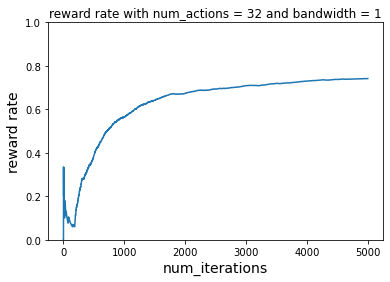

In [9]:
num_iterations = 5000

num_actions = 32
bandwidth = 1

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    "--cats "
    + str(num_actions)
    + "  --bandwidth "
    + str(bandwidth)
    + " --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)
ctr, hits = run_simulation(
    vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=True
)
vw.finish()
plot_reward_rate(
    num_iterations, ctr, "reward rate with num_actions = 32 and bandwidth = 1"
)

### Without Learning

Let's do the same but without learning. The reward rate never improves and just hovers around 0.5

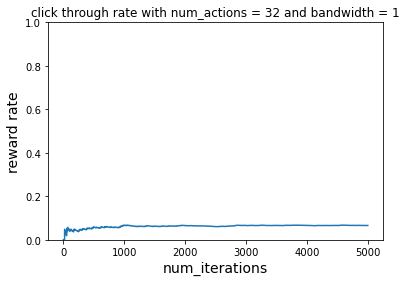

In [10]:
num_iterations = 5000

num_actions = 32
bandwidth = 1

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    "--cats "
    + str(num_actions)
    + "  --bandwidth "
    + str(bandwidth)
    + " --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)
ctr, hits = run_simulation(
    vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=False
)
vw.finish()
plot_reward_rate(
    num_iterations, ctr, "click through rate with num_actions = 32 and bandwidth = 1"
)

## Parameter sweep

Next let's do a parameter sweep for different values of `num_actions` and `bandwidth`. We will use the below function to help us plot the reward rates for different combinations of `num_actions` and `bandwidths`

In [11]:
def plot_reward_sweep(num_iterations, actions, bandwidths, data):
    plt.show()
    n_actions = len(actions)
    n_bandwidths = len(bandwidths)
    fig, axs = plt.subplots(n_actions, n_bandwidths)
    for i in range(0, len(actions)):
        for j in range(0, len(bandwidths)):
            if bandwidths[j] >= actions[i]:
                axs[i, j].set_title("NA")
                continue
            reward_rate, hits = data[str(actions[i])][str(bandwidths[j])]
            hits_percentage = (hits / (num_iterations)) * 100
            axs[i, j].plot(range(1, num_iterations + 1), reward_rate)
            axs[i, j].set_title(
                "hits {:.2f}% TR {:.2f}%".format(hits_percentage, reward_rate[-1] * 100)
            )
            axs[i, j].set_ylim([0, 1])

    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            ax.set_xlabel("b: " + str(bandwidths[j % len(bandwidths)]), fontsize=14)
            ax.set_ylabel("k: " + str(actions[i % len(actions)]), fontsize=14)

    fig.text(0.5, 0.04, "num_iterations", ha="center", fontsize=14)
    fig.text(0.04, 0.5, "reward_rate", va="center", rotation="vertical", fontsize=14)
    fig.set_figheight(18)
    fig.set_figwidth(30)
    plt.suptitle("#examples {}".format(num_iterations))

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

### With Learning

We will try all the number of actions as powers of 2 from 8 until 2048. Since our continuous range stays the same (0-32) we are creating smaller range buckets as the number of actions grows. The number of actions needs to be a power of 2 as it represents the number of leaves that the internal binary tree will have. Small number of actions might result in coarser discretizaton leading to results similar to uniform random. On the other hand really large number of actions could mean that we need a lot more data in order to train all of the buckets.

We will also try all the combinaitons of the above action numbers with bandwidths ranging from 0 to 25. The smaller the bandwidth the smaller the smoothing range around the selected continuous value. Really large bandwidths will result in large smoothing ranges and could lead to results similar to uniform random.

Running simulation for: --cats 8 and --bandwidth 0
Running simulation for: --cats 8 and --bandwidth 1
Running simulation for: --cats 8 and --bandwidth 2
Running simulation for: --cats 8 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 0
Running simulation for: --cats 32 and --bandwidth 1
Running simulation for: --cats 32 and --bandwidth 2
Running simulation for: --cats 32 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 25
Running simulation for: --cats 64 and --bandwidth 0
Running simulation for: --cats 64 and --bandwidth 1
Running simulation for: --cats 64 and --bandwidth 2
Running simulation for: --cats 64 and --bandwidth 3
Running simulation for: --cats 64 and --bandwidth 25
Running simulation for: --cats 128 and --bandwidth 0
Running simulation for: --cats 128 and --bandwidth 1
Running simulation for: --cats 128 and --bandwidth 2
Running simulation for: --cats 128 and --bandwidth 3
Running simulation for: --cats 128 and --bandwidth 25
Running 

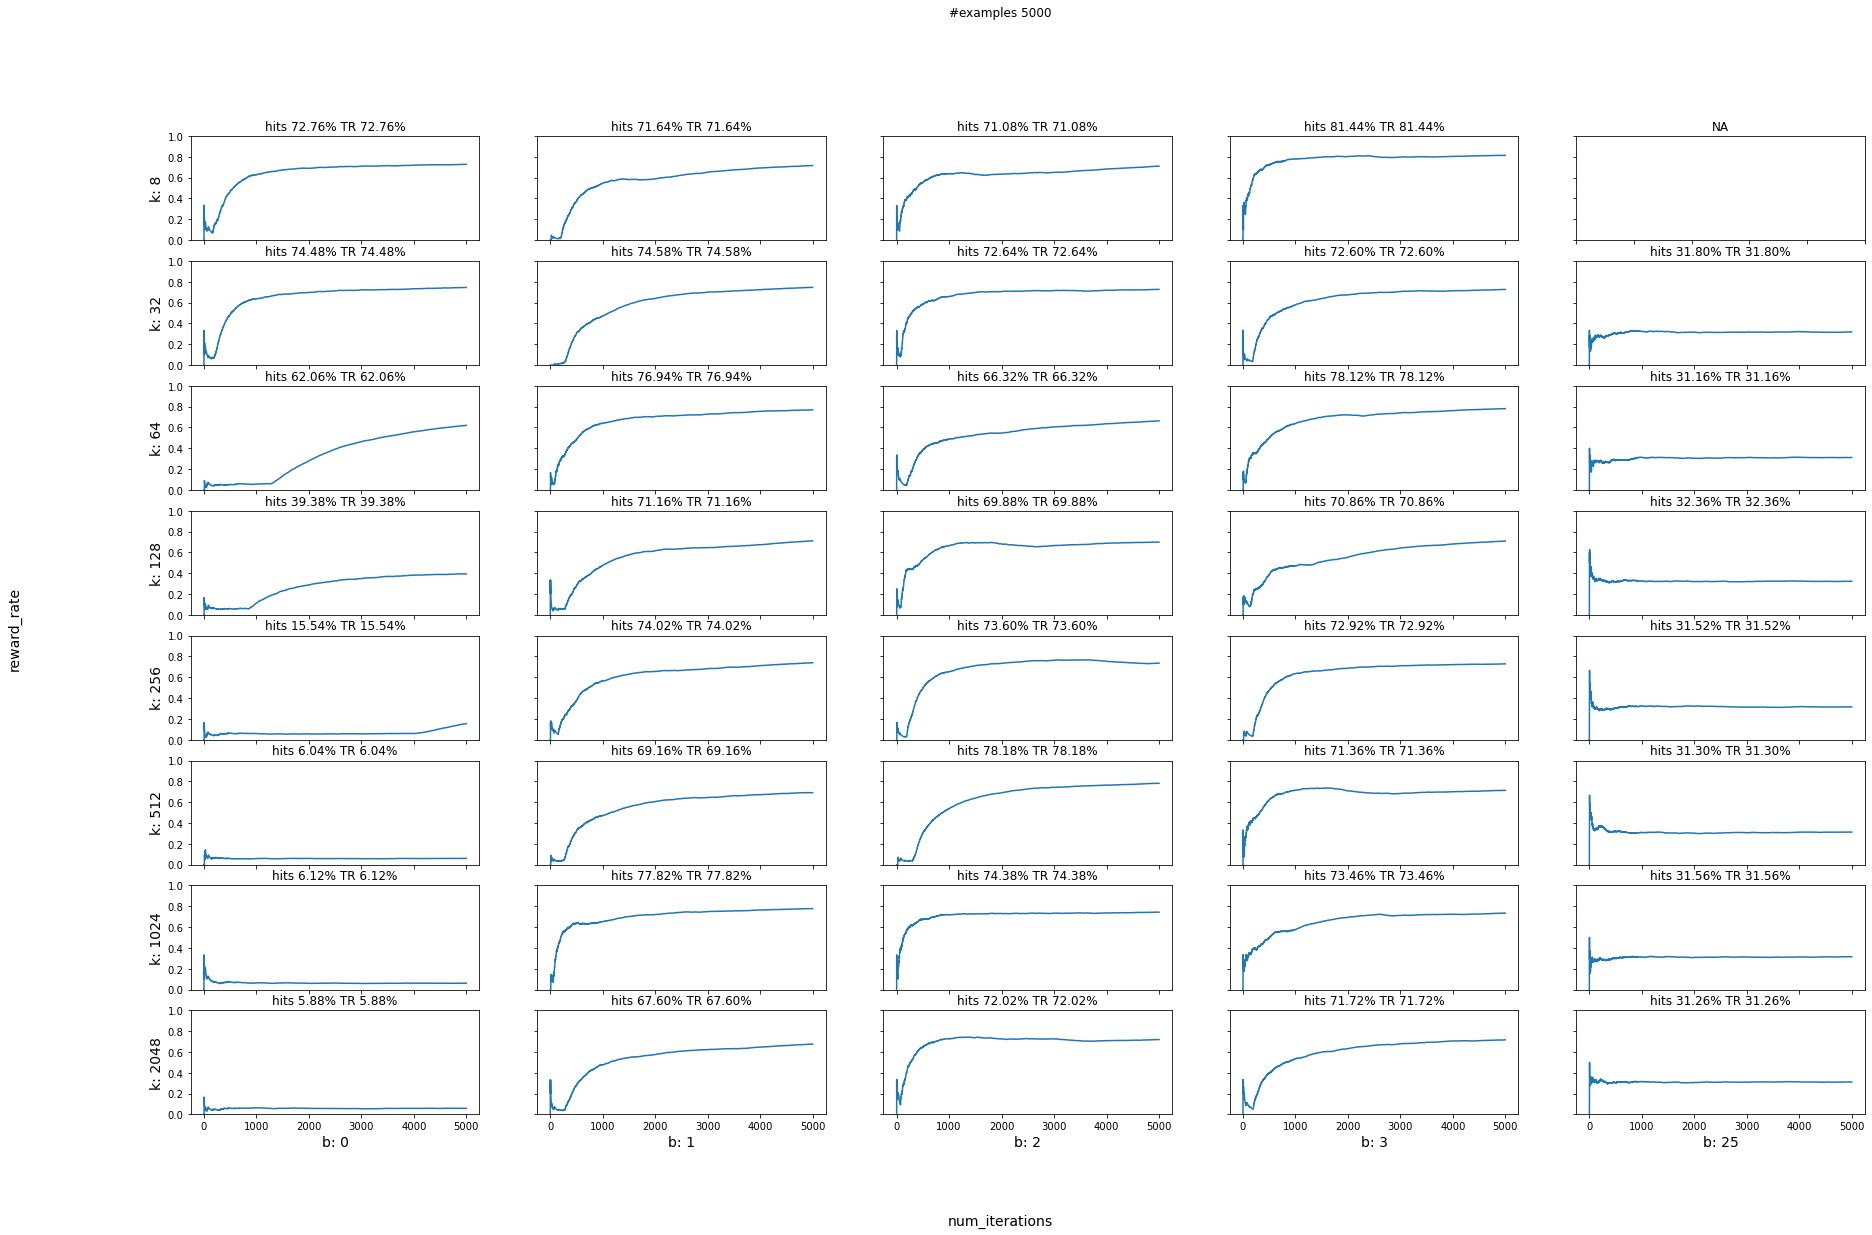

In [12]:
# do parameter sweeping
data = {}
num_actions = [8, 32, 64, 128, 256, 512, 1024, 2048]
bandwidths = [0, 1, 2, 3, 25]

num_iterations = 5000

for actions in num_actions:
    for bd in bandwidths:
        if str(actions) not in data:
            data[str(actions)] = {}
        if bd >= actions:
            continue
        print(f"Running simulation for: --cats {actions} and --bandwidth {bd}")
        vw = vowpalwabbit.Workspace(
            f"--cats {actions}  --bandwidth {bd} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
        )
        rr, hits = run_simulation(
            vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=True
        )
        vw.finish()

        data[str(actions)][str(bd)] = (rr, hits)

plot_reward_sweep(num_iterations, num_actions, bandwidths, data)

### Without Learning

Running simulation for: --cats 8 and --bandwidth 0
Running simulation for: --cats 8 and --bandwidth 1
Running simulation for: --cats 8 and --bandwidth 2
Running simulation for: --cats 8 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 0
Running simulation for: --cats 32 and --bandwidth 1
Running simulation for: --cats 32 and --bandwidth 2
Running simulation for: --cats 32 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 25
Running simulation for: --cats 64 and --bandwidth 0
Running simulation for: --cats 64 and --bandwidth 1
Running simulation for: --cats 64 and --bandwidth 2
Running simulation for: --cats 64 and --bandwidth 3
Running simulation for: --cats 64 and --bandwidth 25
Running simulation for: --cats 128 and --bandwidth 0
Running simulation for: --cats 128 and --bandwidth 1
Running simulation for: --cats 128 and --bandwidth 2
Running simulation for: --cats 128 and --bandwidth 3
Running simulation for: --cats 128 and --bandwidth 25
Running 

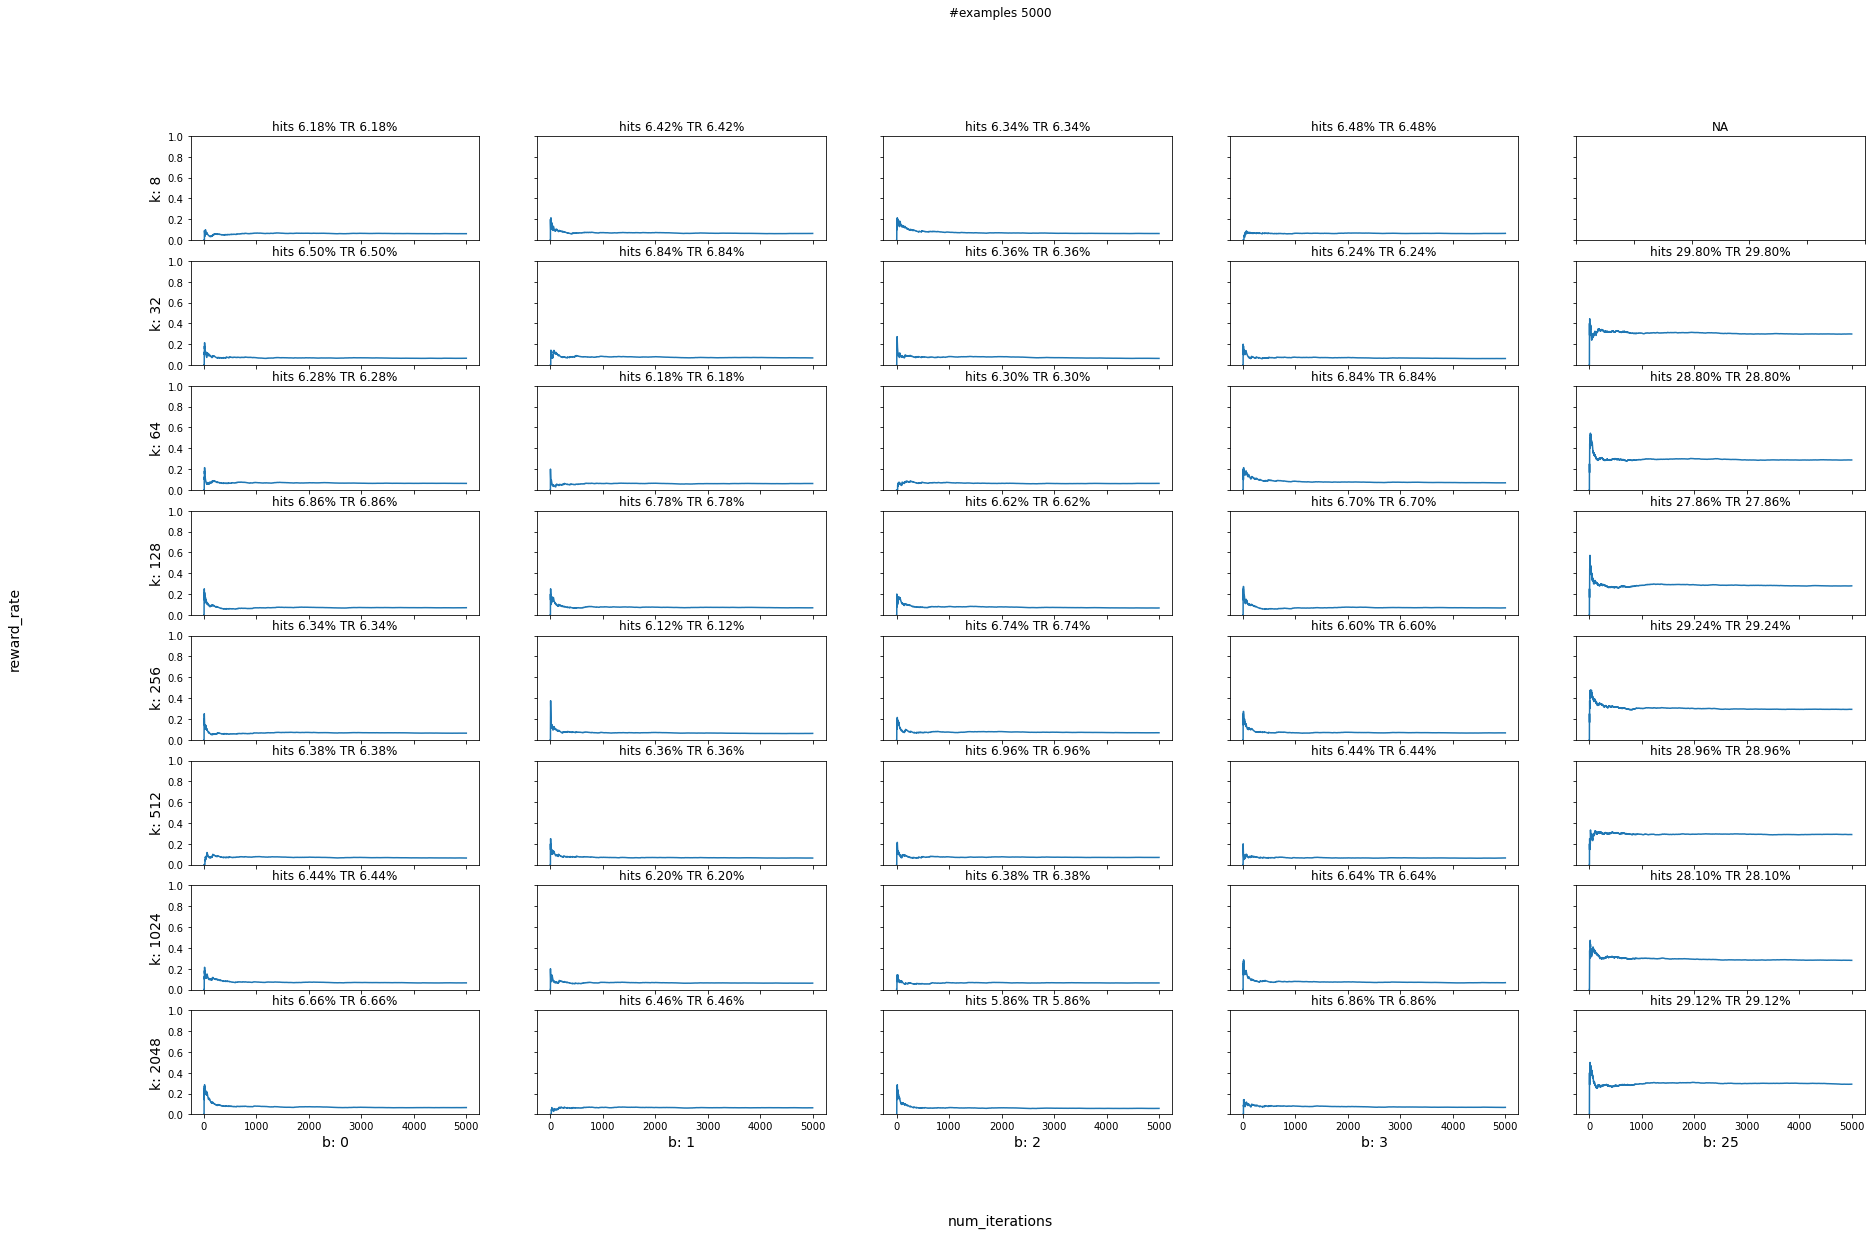

In [13]:
# do parameter sweeping
data = {}
num_actions = [8, 32, 64, 128, 256, 512, 1024, 2048]
bandwidths = [0, 1, 2, 3, 25]

num_iterations = 5000

for actions in num_actions:
    for bd in bandwidths:
        if str(actions) not in data:
            data[str(actions)] = {}
        if bd >= actions:
            continue
        print(f"Running simulation for: --cats {actions} and --bandwidth {bd}")
        vw = vowpalwabbit.Workspace(
            f"--cats {actions} --bandwidth {bd} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
        )
        rr, hits = run_simulation(
            vw, num_iterations, rooms, times_of_day, get_cost, 0, 32, do_learn=False
        )
        vw.finish()
        data[str(actions)][str(bd)] = (rr, hits)

plot_reward_sweep(num_iterations, num_actions, bandwidths, data)

## Scenario 2

In the real world peoples preferences change as e.g. the seasons change. So now in the simulation we are going to incorporate two different cost functions, and swap over to the second one halfway through. Below is a a table of the new cost function we are going to use, get_cost_1:

### Living Room

 | | get_cost | get_cost_1 |
 |:---|:---:|:---:|
 | **Morning** | Cold | Hot |
 | **Afternoon** | Hot | Cold |

 
 ### Bedroom

 | | get_cost | get_cost_1 |
 |:---|:---:|:---:|
 | **Morning** | Hot | Cold |
 | **Afternoon** | Cold | Cold |


Below we define the new cost function
 

In [14]:
def get_cost_1(context, temperature, min_value, max_value):
    range = float(max_value - min_value)
    if context["room"] == "Living Room":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(25, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    elif context["room"] == "Bedroom":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    else:
        return USER_DISLIKED_TEMPERATURE

To make it easy to show the effect of the cost function changing we are going to modify the run_simulation function. It is a little less readable now, but it supports accepting a list of cost functions and it will operate over each cost function in turn.

In [15]:
def run_simulation_multiple_cost_functions(
    vw,
    num_iterations,
    rooms,
    times_of_day,
    cost_functions,
    min_value,
    max_value,
    do_learn=True,
):

    reward_rate = []
    hits = 0
    cost_sum = 0.0

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. In each simulation choose a room
            room = choose_room(rooms)
            # 2. Choose time of day for a given room
            time_of_day = choose_time_of_day(times_of_day)
            # 3. Pass context to vw to get a temperature
            context = {"room": room, "time_of_day": time_of_day}
            temperature, pdf_value = predict_temperature(vw, context)

            # 4. Get cost of the action we chose
            cost = cost_function(context, temperature, min_value, max_value)
            if cost <= -0.75:  # count something as a hit only if it has a high reward
                hits += 1
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                txt_ex = to_vw_example_format(
                    context, cats_label=(temperature, cost, pdf_value)
                )
                vw_format = vw.parse(txt_ex, vowpalwabbit.LabelType.CONTINUOUS)
                # 6. Learn
                vw.learn(vw_format)
                # 7. Let VW know you're done with these objects
                vw.finish_example(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            reward_rate.append(-1 * cost_sum / i)

        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return reward_rate, hits

### With Learning

Now that we have run a parameter sweep we can better pick the values of num_actions and bandwidth. For the next scenario we will pick `num_actions 128` and `bandwidth 2`.

Let us now switch to the second cost function after a few samples (running the first cost function). Recall that this cost function changes the preferences of the room temperatures but it is still working with the same continuous action space as before. We should see the learner pick up these changes and optimize towards the new preferences.



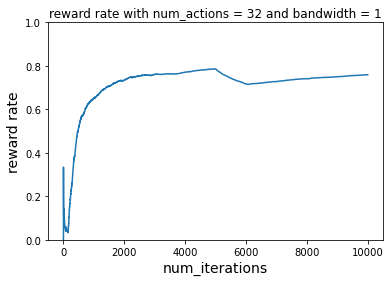

In [16]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
num_actions = 128
bandwidth = 2

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    f"--cats {num_actions}  --bandwidth {bandwidth} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, hits = run_simulation_multiple_cost_functions(
    vw,
    num_iterations_per_cost_func,
    rooms,
    times_of_day,
    cost_functions,
    0,
    32,
    do_learn=True,
)
vw.finish()
plot_reward_rate(
    total_iterations, ctr, "reward rate with num_actions = 32 and bandwidth = 1"
)

### Without Learning

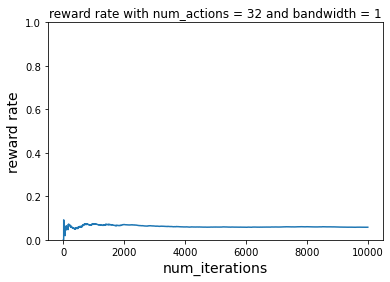

In [17]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
num_actions = 128
bandwidth = 2

# Instantiate VW learner
vw = vowpalwabbit.Workspace(
    f"--cats {num_actions} --bandwidth {bandwidth} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
)

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr, hits = run_simulation_multiple_cost_functions(
    vw,
    num_iterations_per_cost_func,
    rooms,
    times_of_day,
    cost_functions,
    0,
    32,
    do_learn=False,
)
vw.finish()
plot_reward_rate(
    total_iterations, ctr, "reward rate with num_actions = 32 and bandwidth = 1"
)

## Scenario 3

### Better cost function

The cost function we have been using until now has been a bit too simplistic but has served us well enough to showcase the differences in learning and also in showing CB pickup the new cost cost function and adjust to it.

A slightly better cost function for our simulated world could be the difference between the temperature recommended and the temperature chosen. The smaller the difference the better the thermostat is doing. We are going to model that by taking the absolute cost: `1.0 - |selected_temperature - predicted_temerature| / range` and the transforming that cost into a reward by multiplying it with `-1`

In [18]:
def get_smooth_cost(context, temperature, min_value, max_value):
    range = float(max_value - min_value)
    if context["room"] == "Living Room":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(25, 29)
            # the absolute difference between selected temperature and proposed temperature
            cost = 1.0 - math.fabs(selected_temperature - temperature) / range
            return -1.0 * cost
        elif context["time_of_day"] == "afternoon":
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            cost = 1.0 - math.fabs(selected_temperature - temperature) / range
            return -1.0 * cost
        else:
            return USER_DISLIKED_TEMPERATURE
    elif context["room"] == "Bedroom":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            cost = 1.0 - math.fabs(selected_temperature - temperature) / range
            return -1.0 * cost
        elif context["time_of_day"] == "afternoon":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            cost = 1.0 - math.fabs(selected_temperature - temperature) / range
            return -1.0 * cost
        else:
            return USER_DISLIKED_TEMPERATURE
    else:
        return USER_DISLIKED_TEMPERATURE

Let's try the original paramter sweep with the new cost function `get_smooth_cost`

Running simulation for: --cats 8 and --bandwidth 0
Running simulation for: --cats 8 and --bandwidth 1
Running simulation for: --cats 8 and --bandwidth 2
Running simulation for: --cats 8 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 0
Running simulation for: --cats 32 and --bandwidth 1
Running simulation for: --cats 32 and --bandwidth 2
Running simulation for: --cats 32 and --bandwidth 3
Running simulation for: --cats 32 and --bandwidth 25
Running simulation for: --cats 64 and --bandwidth 0
Running simulation for: --cats 64 and --bandwidth 1
Running simulation for: --cats 64 and --bandwidth 2
Running simulation for: --cats 64 and --bandwidth 3
Running simulation for: --cats 64 and --bandwidth 25
Running simulation for: --cats 128 and --bandwidth 0
Running simulation for: --cats 128 and --bandwidth 1
Running simulation for: --cats 128 and --bandwidth 2
Running simulation for: --cats 128 and --bandwidth 3
Running simulation for: --cats 128 and --bandwidth 25
Running 

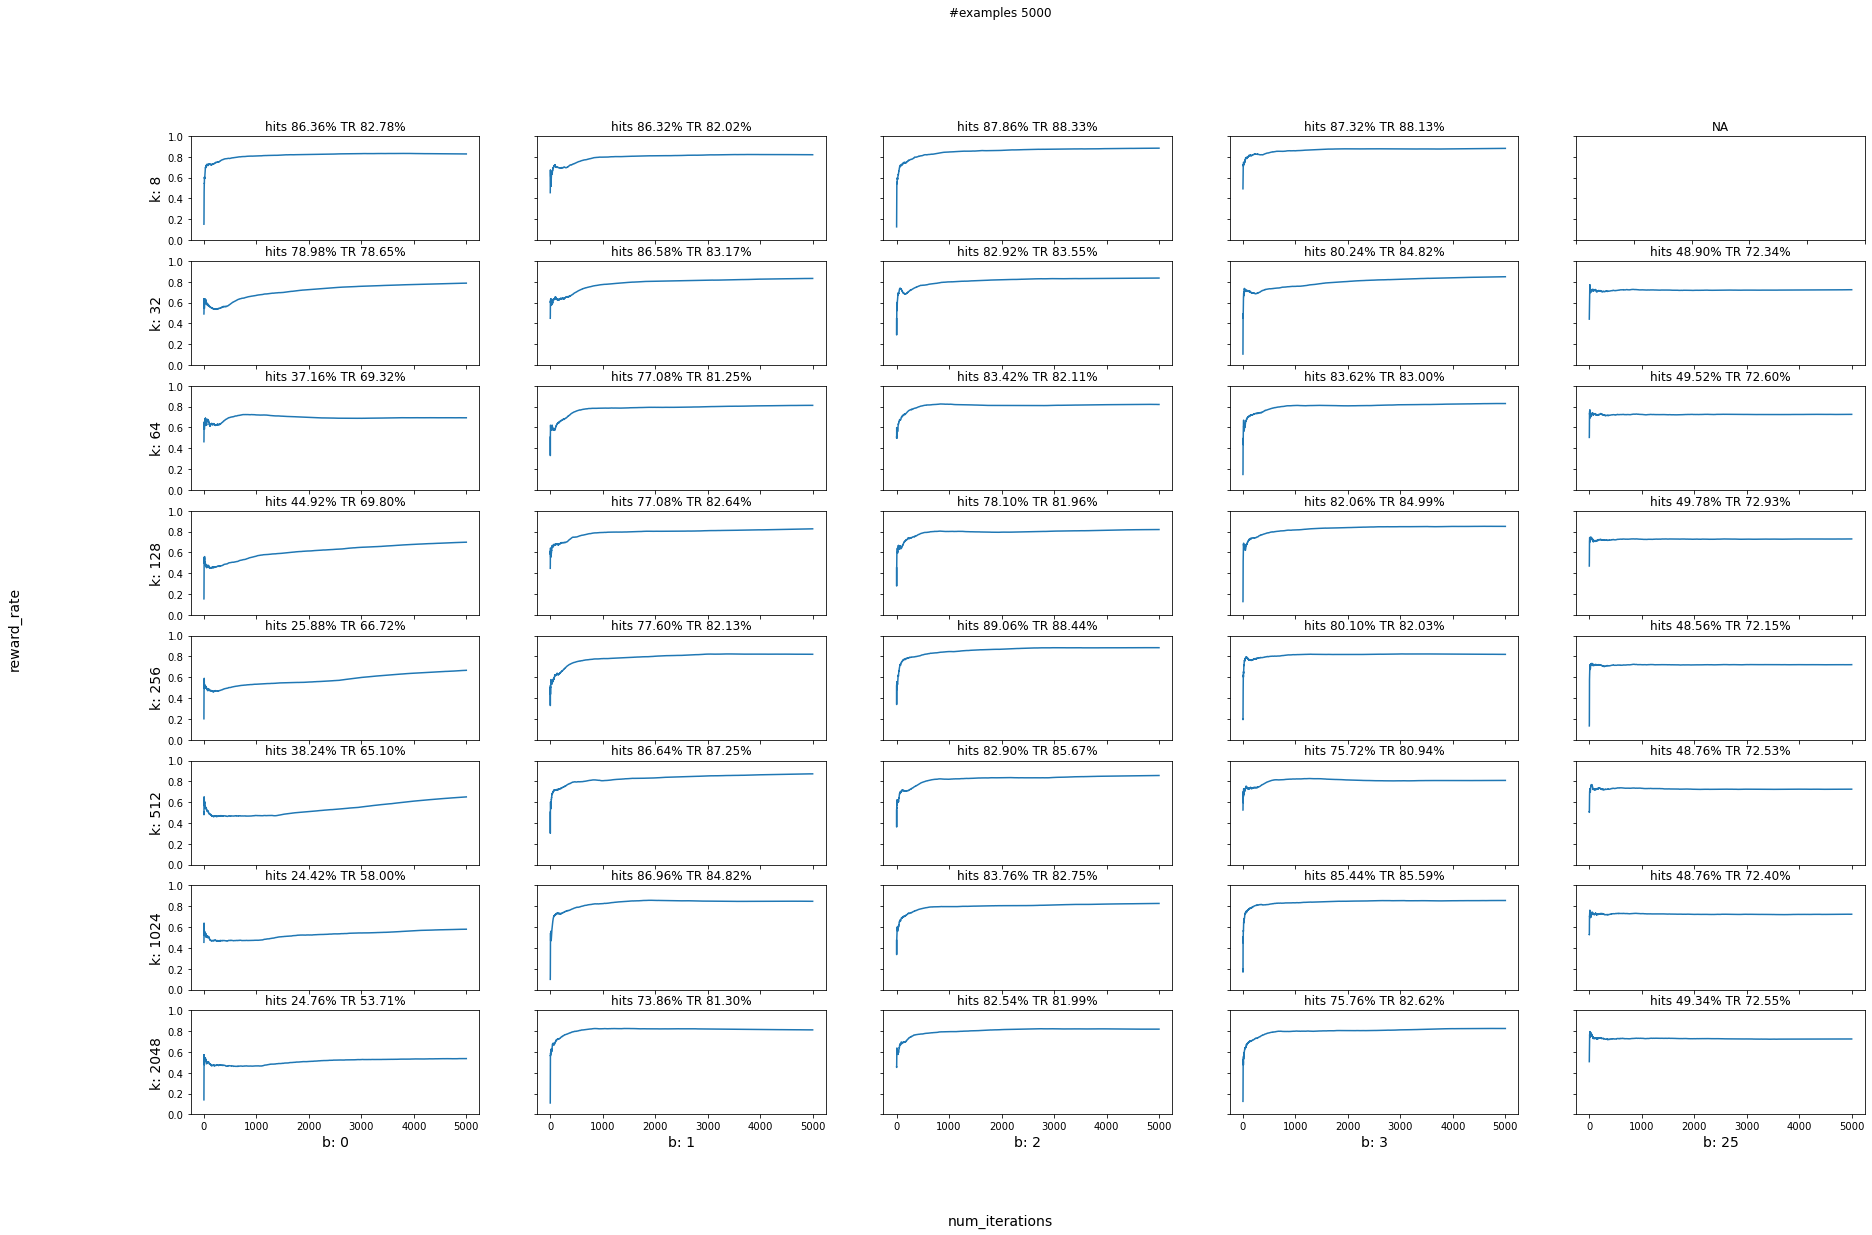

In [19]:
# do parameter sweeping
data = {}
num_actions = [8, 32, 64, 128, 256, 512, 1024, 2048]
bandwidths = [0, 1, 2, 3, 25]

num_iterations = 5000

for actions in num_actions:
    for bd in bandwidths:
        if str(actions) not in data:
            data[str(actions)] = {}
        if bd >= actions:
            continue
        print(f"Running simulation for: --cats {actions} and --bandwidth {bd}")
        vw = vowpalwabbit.Workspace(
            f"--cats {actions}  --bandwidth {bd} --min_value 0 --max_value 32 --json --chain_hash --coin --epsilon 0.2 -q :: --quiet"
        )
        rr, hits = run_simulation(
            vw,
            num_iterations,
            rooms,
            times_of_day,
            get_smooth_cost,
            0,
            32,
            do_learn=True,
        )
        vw.finish()
        data[str(actions)][str(bd)] = (rr, hits)

plot_reward_sweep(num_iterations, num_actions, bandwidths, data)